# Маркетинг

## Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

## Цель

Предсказать вероятность покупки в течение 90 дней.

## Задачи

- Изучить данные;
- Разработать полезные признаки;
- Создать модель для классификации пользователей;
- Улучшить модель и максимизировать метрику roc_auc;
- Выполнить тестирование.

## Данные

**apparel-purchases** - история покупок:

- client_id идентификатор пользователя;
- quantity количество товаров в заказе;
- price цена товара;
- category_ids вложенные категории, к которым отнсится товар;
- date дата покупки;
- message_id идентификатор сообщения из рассылки.

**apparel-messages** - история рекламных рассылок:

- bulk_campaign_id идентификатор рекламной кампании;
- client_id идентификатор пользователя;
- message_id идентификатор сообщений;
- event тип действия;
- channel канал рассылки;
- date дата рассылки;
- created_at точное время создания сообщения.

**apparel-target_binary** - совершит ли клиент покупку в течение следующих 90 дней:

- client_id идентификатор пользователя;
- target целевой признак.

## Установка модулей

In [1]:
# !pip install phik -q
# !pip install lightgbm -q
# !pip install --upgrade pandas -q

## Загрузка модулей

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

## Загрузка функций

In [3]:
def convert_str_lst(string):
    """Функция преобразует строку похожую на список в список."""
    if string in ['[None]', '[]']:
        return np.nan
    lst = string.replace("'", "")[1:-1].split(', ')
    return list(map(lambda x: np.nan if x=='None' else int(x), lst))

def select_features(phik_matrix, target, threshold=0.05, multicollinearity_thresh=0.9):
    """Отбирает в матрице phik-корреляции только те признаки, которые больше заданного порога,
    затем в полученных признаках убирает признаки, которое сильно  коррелируют с остальными."""
    target_corr = phik_matrix[target].sort_values(ascending=False)

    true_features = target_corr[target_corr>threshold].index.tolist()
    true_features.remove(target)

    selected_features = []
    for feature in true_features:
        collinear = False
        for selected in selected_features:
            if phik_matrix.loc[feature, selected] > multicollinearity_thresh:
                collinear = True
                break
        if not collinear:
            selected_features.append(feature)
    return selected_features

def get_metrics(grid_search, X_train, y_train):
    grid_search.fit(X_train, y_train)
    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"roc_auc = : {grid_search.best_score_:.2f}")

## Загрузка датафремов

In [4]:
purchases = pd.read_csv('apparel-purchases.csv', parse_dates=['date'])
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [5]:
messages = pd.read_csv('apparel-messages.csv', parse_dates=['date', 'created_at'])
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [6]:
target = pd.read_csv('apparel-target_binary.csv')
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Датасеты корректно загружены в датафреймы.

## Анализ датафреймов

### apparel-purchases

In [7]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


В датафрейме более 200 тыс. строк и 6 столбцов, из них: 3 – числовые, 2 категориальные, 1 – дата.
При чём значения в столбце **category_ids** выглядят как список, а на самом деле являются строкой. Необходимо будет преобразовать их в список.



In [8]:
purchases.duplicated().sum()

73020

73 тыс. дубликатов из 200 тыс. строк. Удалим их.

In [9]:
purchases = purchases.drop_duplicates()

Разберемся с проблемой в столбце **category_ids**. Для начала преобразуем значения этого столбца в списки.

In [10]:
purchases['category_ids'] = purchases['category_ids'].apply(convert_str_lst)
purchases.head(2)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d


In [11]:
purchases.category_ids[0][0]

4

In [12]:
purchases.isna().mean()

client_id       0.000000
quantity        0.000000
price           0.000000
category_ids    0.026009
date            0.000000
message_id      0.000000
dtype: float64

In [13]:
print(purchases.shape)
purchases[['client_id', 'message_id', ]].nunique()


(129188, 6)


client_id     49849
message_id    50204
dtype: int64

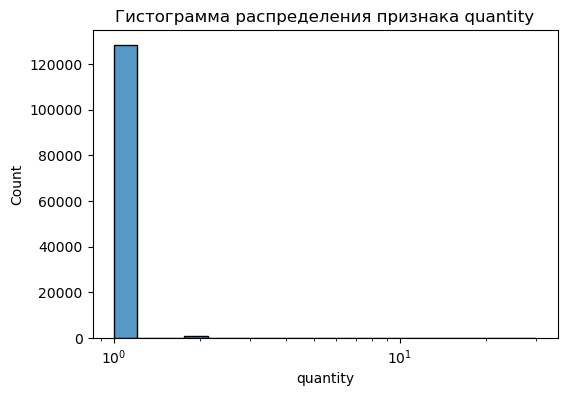

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(purchases['quantity'],log_scale=True)
plt.title('Гистограмма распределения признака quantity');


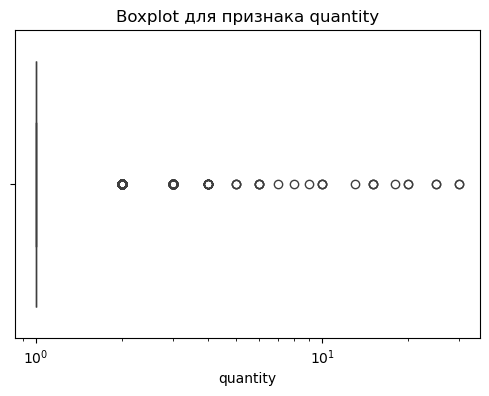

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(data=purchases, x='quantity', log_scale=True)
plt.title('Boxplot для признака quantity');

In [16]:
purchases['quantity'].value_counts(normalize=True).round(2)

quantity
1     0.99
2     0.01
3     0.00
4     0.00
6     0.00
10    0.00
15    0.00
5     0.00
25    0.00
20    0.00
30    0.00
13    0.00
18    0.00
8     0.00
9     0.00
7     0.00
Name: proportion, dtype: float64

Чаще всего (в 99% случаев) в заказе количество товаров  = 1.

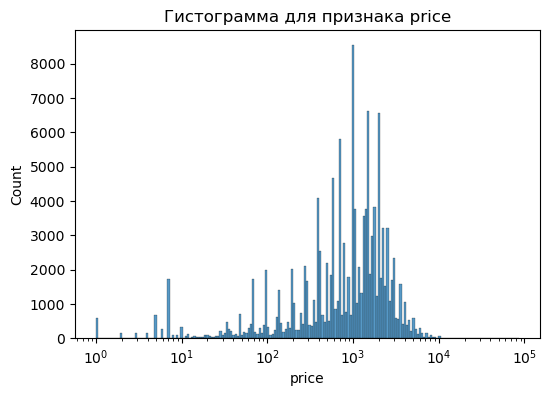

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(data=purchases, x='price', log_scale=True)
plt.title('Гистограмма для признака price');

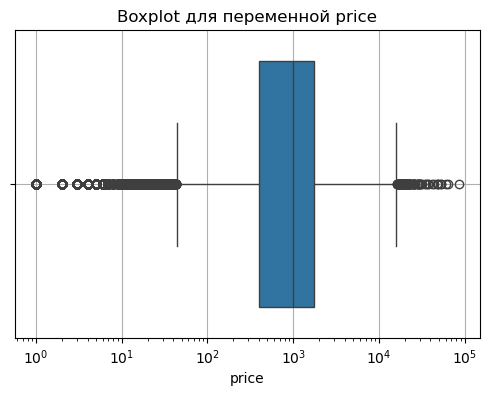

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(data=purchases, x='price', log_scale=True)
plt.title('Boxplot для переменной price')
plt.grid()

In [19]:
print(f"Граница нижняя: {10**1.3:.0f}, граница верхняя: {10**4.1:.0f}")

Граница нижняя: 20, граница верхняя: 12589


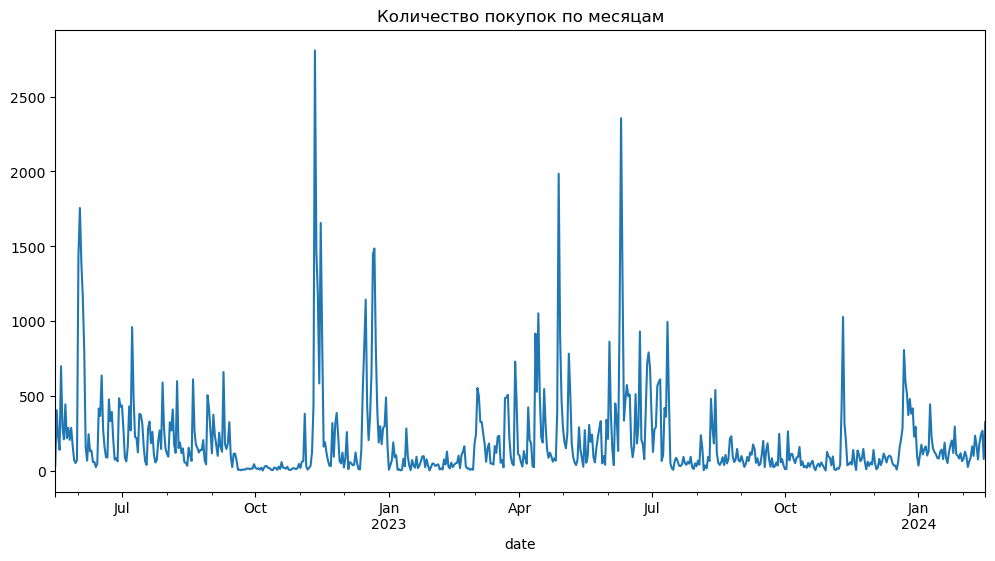

In [20]:
purchases['date'].value_counts().sort_index().plot(kind='line', figsize=(12, 6))
plt.title('Количество покупок по месяцам')
plt.show()

По графику видно, что больше всего покупок было в ноябре 2022 и мае - июне 2023.

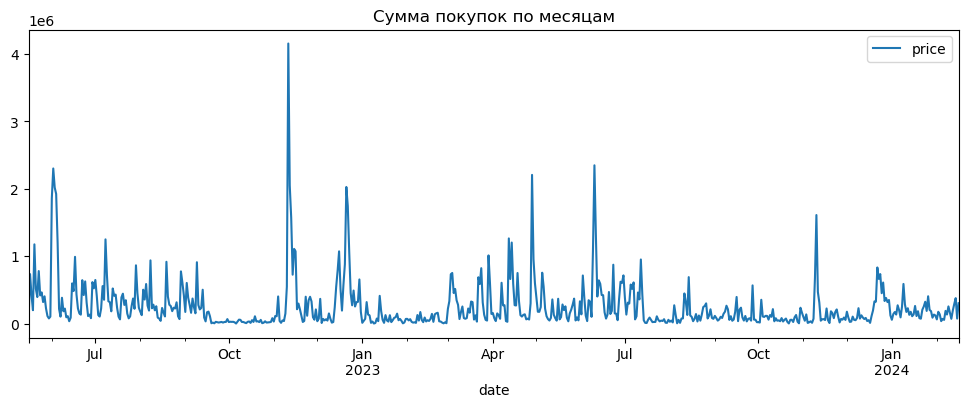

In [21]:
purchases.groupby('date').agg({'price':'sum'}).plot(kind='line', figsize=(12, 4))
plt.title('Сумма покупок по месяцам')
plt.show()

Соответственно и сумма покупок была больше в эти месяцы.

#### Создание признаков на основе категории товаров


Создадим признаки на основе колонки **category_ids**.

In [22]:
purchases

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202196,1515915626010221592,1,1499.0,"[4, 28, 260, 1194]",2024-02-16,1515915626010221592-14664-65cf1622434a9
202198,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490


In [23]:
purchases['level_0'] = purchases['category_ids'].apply(lambda x: np.nan if x is np.nan else x[0])
purchases['level_1'] = purchases['category_ids'].apply(lambda x: np.nan if x is np.nan else x[1])
purchases['level_2'] = purchases['category_ids'].apply(lambda x: np.nan if x is np.nan else x[2])
purchases['level_3'] = purchases['category_ids'].apply(lambda x: np.nan if x is np.nan else x[-1])

Для каждого клиента вычисли сколько уникальных товаров он покупает на каждом уровне.

In [24]:
purchases_diversity = purchases.groupby('client_id').agg(level_0_unique=('level_0', 'nunique'),
                                   level_1_unique=('level_1', 'nunique'),
                                   level_2_unique=('level_2', 'nunique'),
                                   level_3_unique=('level_3', 'nunique'))
purchases_diversity.head()

,level_0_unique,level_1_unique,level_2_unique,level_3_unique
client_id,,,,
1515915625468060902,1,2,5,5
1515915625468061003,1,1,1,1
1515915625468061099,1,1,1,1
1515915625468061100,1,1,1,1
1515915625468061170,2,2,3,3


#### Создание признаков на основе количества и цены товаров

Вычислим для каждого клиента среднее количество товаров и среднюю цену за покупку, а также любимую категорию (подкатегорию) на уровне 0 и 1.

In [25]:
purchases[['level_0', 'level_1', 'level_2']] = purchases[['level_0', 'level_1', 'level_2']].fillna(0)

In [26]:
purchases_agg = purchases.groupby('client_id').agg(quantity_mean=('quantity', 'mean'),
                                   price_mean=('price', 'mean'),
                                   level_0_mode=('level_0', lambda x: x.mode().iloc[0]),
                                   level_1_mode=('level_1', lambda x: x.mode().iloc[0]))
purchases_agg.head(2)

,quantity_mean,price_mean,level_0_mode,level_1_mode
client_id,,,,
1515915625468060902,1.0,959.000000,4.0,28.0
1515915625468061003,1.0,2355.833333,4.0,28.0


#### Создание признака среднее количестов покупок в месяц

Вычислим для каждого клиента среднее количество товаров и среднюю цену за месяц.

In [27]:
purchases['start_month'] = purchases['date'].dt.to_period('M').dt.to_timestamp()

In [28]:
purchases_by_month = purchases.groupby(['client_id', 'start_month']).agg(month_quantity_mean=('quantity', 'sum'),
                                                                         month_price_mean=('price', 'sum')) \
                              .groupby('client_id').agg({'month_quantity_mean':'mean',
                                                         'month_price_mean':'mean'})
purchases_by_month.head(2)

,month_quantity_mean,month_price_mean
client_id,,
1515915625468060902,5.0,4795.0
1515915625468061003,6.0,14135.0


#### Создание признаков на основе message_id

Вычислим для каждого клиента среднее количество товаров и среднюю цену за одну рекламную рассылку после которой клиент принял решение купить какой либо товар.

In [29]:
purchases_by_message = purchases.groupby(['client_id', 'message_id']).agg(quantity_by_message=('quantity', 'sum'),
                                                   price_by_message=('price','sum')) \
                                .groupby('client_id').agg({'quantity_by_message':'mean',
                                                            'price_by_message':'mean'}).round(2)
purchases_by_message.head(2)

,quantity_by_message,price_by_message
client_id,,
1515915625468060902,5.0,4795.0
1515915625468061003,6.0,14135.0


### apparel-messages

In [30]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


В датафрейме более 12 млн. строк и 7 столбцов, 2 из которых числовые, 3 категориальные, 2 - в формате datetime.

In [31]:
messages.duplicated().sum()

48610

В датафрейме очень много дубликатов. Сразу избавимся от них.

In [32]:
messages = messages.drop_duplicates()

In [33]:
messages.isna().mean()

bulk_campaign_id    0.0
client_id           0.0
message_id          0.0
event               0.0
channel             0.0
date                0.0
created_at          0.0
dtype: float64

Пропущенных значений нет.

In [34]:
messages[['bulk_campaign_id','client_id', 'message_id']].nunique()

bulk_campaign_id       2709
client_id             53329
message_id          9061667
dtype: int64

In [35]:
messages.query("event == 'purchase'").nunique()

bulk_campaign_id     1528
client_id           42055
message_id          49671
event                   1
channel                 2
date                  638
created_at          60471
dtype: int64

In [36]:
client_campaign_mean = messages.groupby('client_id').agg({'bulk_campaign_id':'count'}).mean().values[0].round()
client_message_mean = messages.groupby('client_id').agg({'message_id':'count'}).mean().values[0].round()
print(f"Среднее количество кампаний в которых участвует клиент: {client_campaign_mean}")
print(f"Среднее количество сообщений которые получает клиент: {client_message_mean}")

Среднее количество кампаний в которых участвует клиент: 238.0
Среднее количество сообщений которые получает клиент: 238.0


In [37]:
messages.groupby('client_id').agg({'message_id':'count'})

,message_id
client_id,
1515915625468060902,177
1515915625468061003,165
1515915625468061099,276
1515915625468061100,428
1515915625468061170,293
...,...
1515915626010183608,4
1515915626010221592,6
1515915626010234726,1


In [38]:
messages[['event', 'channel']].nunique()

event      11
channel     2
dtype: int64

In [39]:
messages['event'].value_counts(normalize=True).round(2)

event
send           0.71
open           0.24
click          0.04
purchase       0.00
hard_bounce    0.00
soft_bounce    0.00
unsubscribe    0.00
hbq_spam       0.00
complain       0.00
subscribe      0.00
close          0.00
Name: proportion, dtype: float64

В колонке **event** значение **send** - указывает на то, что сообщение доставлено, и возможно для обучения модели эта информация не сильно то нужна, а вот значения **open** и **click** уже указывают на некоторую активность и заинтересованность пользователя к рекламной рассылке, значения **purchase** - вообще указывает на сам факт покупки (таргет). Остальные значения в выборке представлены крайне мало и несут чисто техническую информацию, о том, что есть проблемы с доставкой и т.п. и ими можно пренебречь, т.е. удалить из выборки.

In [40]:
messages['channel'].value_counts(normalize=True).round(2)

channel
mobile_push    0.59
email          0.41
Name: proportion, dtype: float64

Канал mobile_push немного чаще используется чем email.

In [41]:
(messages['created_at'].dt.date != messages['date'].dt.date).sum()

0

Если сравнивать только даты в колонках **created_at** и **date**, то они одинаковы. Значит наличие колонка date в датафрейме избыточно, ее можно удалить.

#### Создание признака activity

Создадим признак activity который показывает активность клиента при взаимодействии с сообщениями и определяется по формуле:

 $\text{activity} = \frac{\text{open} + \text{click}}{\text{send}}$

In [42]:
# Вычиисляем числитель
t_1 = messages.query("event in ('open', 'click')") \
                          .groupby(['client_id']).agg(numerator=('event', 'count'))
# Выччисляем знаменатель. Так как send пропущен, просто вычиляем количество уникльных значений.
t_2 = messages.query("event in ('send', 'open', 'click')") \
                          .groupby(['client_id']).agg(denominator=('message_id', 'nunique'))

client_activity = t_1.merge(t_2, how='outer', on='client_id').fillna(0)

client_activity['activity'] = (client_activity['numerator'] / client_activity['denominator']).round(2)
client_activity = client_activity['activity'].reset_index()
client_activity.head()

,client_id,activity
0,1515915625468060902,0.35
1,1515915625468061003,0.06
2,1515915625468061099,0.27
3,1515915625468061100,0.59
4,1515915625468061170,0.19


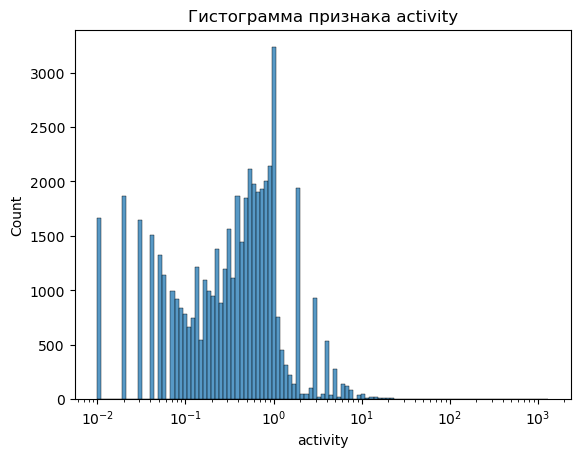

In [43]:
sns.histplot(client_activity['activity'], log_scale=True)
plt.title('Гистограмма признака activity');

#### Создание признака pre_purchase_engagement

Создадим признак **pre_purchase_engagement** - показывающий среднее количество действий, которое совершает клиент после получения сообщения и покупкой товара.

In [44]:
pre_purchase_engagement = messages.query("event in ('open', 'click', 'purchase')") \
        .groupby(['client_id', 'message_id']).agg(pre_purchase_engagement=('event', 'count')) \
        .groupby('client_id').agg({'pre_purchase_engagement':'mean'}).round(2)
pre_purchase_engagement.head(2)

,pre_purchase_engagement
client_id,
1515915625468060902,1.52
1515915625468061003,2.20


#### Создание признаков per_email и per_mobile_push

Создадим признаки указывающую долю использования mail или mobile_push.

In [45]:
percentage_channel = messages.groupby(['client_id', 'message_id']).first() \
            .groupby('client_id').value_counts(subset=['channel'], normalize=True) \
            .unstack(fill_value=0).rename(columns={'email':'per_email', 'mobile_push': 'per_mobile_push'}) \
            .fillna(0).round(2)
percentage_channel.head(2)

channel,per_email,per_mobile_push
client_id,,
1515915625468060902,1.0,0.0
1515915625468061003,1.0,0.0


### apparel-target_binary

In [46]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


В датафрейме всего два столбца и 49_849 строк.

In [47]:
target['client_id'].nunique()

49849

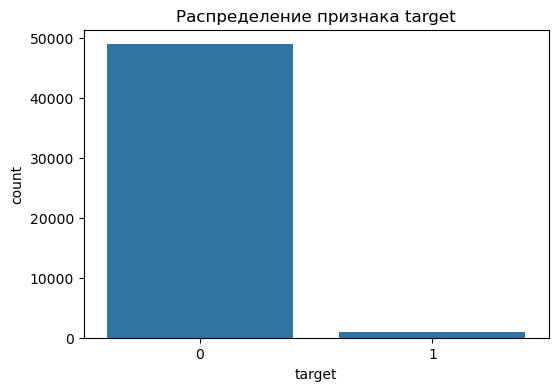

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(data=target, x='target')
plt.title('Распределение признака target');

В выборке примеров положительного класса очень мало, это надо учесть при обучении модели.

### Создание признаков на основе объединенного датафрейма

Объединим два датафрейма **purchases** и **messages** в один и не его основе создадим признаки.

In [49]:
t = purchases.merge(messages, how='inner', on=['client_id', 'message_id'])
t.head(3)

,client_id,quantity,price,category_ids,date_x,message_id,level_0,level_1,level_2,level_3,start_month,bulk_campaign_id,event,channel,date_y,created_at
0,1515915625490739153,1,1999.0,"[2, 18, 123, 451]",2022-05-16,1515915625490739153-4172-626b943cc789b,2.0,18.0,123.0,451.0,2022-05-01,4172,open,email,2022-05-27,2022-05-27 07:52:08
1,1515915625491869271,2,599.0,"[4, 27, 350, 1392]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4.0,27.0,350.0,1392.0,2022-05-01,2090,click,email,2023-04-12,2023-04-12 08:25:33
2,1515915625491869271,2,599.0,"[4, 27, 350, 1392]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4.0,27.0,350.0,1392.0,2022-05-01,2090,click,email,2023-04-18,2023-04-18 11:47:45


#### Создание признаков steps_before_purchase и cost_of_step

Создадим два признака **steps_before_purchase** и **cost_of_step**, показывающие сколько шагов делает клиент при покупке и какая цена у шага, соответственно.

In [50]:
steps = t.groupby(['client_id', 'message_id']).agg(steps_before_purchase=('event', 'count'),
                                           cost_of_step=('price', 'mean')) \
 .groupby('client_id').agg({'steps_before_purchase':'mean',
                            'cost_of_step':'mean'})
steps.head(3)

,steps_before_purchase,cost_of_step
client_id,,
1515915625468060902,55.0,959.000000
1515915625468061003,24.0,2355.833333
1515915625468061100,4.0,1049.000000


#### Создание признака message_to_purchase – время от сообщения до покупки.

Создадим признак **message_to_purchase** - сколько в среднем времени (в секундах) проходит с момента получения сообщения до совершения покупки.

In [51]:
message_to_purchase = t.groupby(['client_id', 'message_id']).agg(min_date=('created_at','min'),
                                           max_date=('created_at', 'max'))
message_to_purchase['message_to_purchase'] = (message_to_purchase['max_date'] - message_to_purchase['min_date']).dt.total_seconds()
message_to_purchase = message_to_purchase.groupby('client_id').agg({'message_to_purchase':'mean'})
message_to_purchase.head()

,message_to_purchase
client_id,
1515915625468060902,23917.000000
1515915625468061003,26518.000000
1515915625468061100,114973.000000
1515915625468061170,344717.666667
1515915625468061514,84516.000000


### Обобщенный датафрейм

Объединим все датафремы между собой.

In [142]:
df = purchases.merge(messages, how='inner', on=['client_id', 'message_id'], suffixes=('_purchase', '_message'))
df = df.merge(target, how='inner', on='client_id')
df = df.merge(purchases_agg, how='left', on='client_id')
df = df.merge(client_activity, how='left', on='client_id')
df = df.merge(pre_purchase_engagement, how='left', on='client_id')
df = df.merge(percentage_channel, how='left', on='client_id')
df = df.merge(purchases_by_month, how='left', on='client_id')
df = df.merge(purchases_diversity, how='left', on='client_id')
df = df.merge(purchases_by_message, how='left', on='client_id')
df = df.merge(steps, how='left', on='client_id')
df = df.merge(message_to_purchase, how='left', on='client_id')
# df = df.fillna(0)
df.head()

,client_id,quantity,price,category_ids,date_purchase,message_id,level_0,level_1,level_2,level_3,...,month_price_mean,level_0_unique,level_1_unique,level_2_unique,level_3_unique,quantity_by_message,price_by_message,steps_before_purchase,cost_of_step,message_to_purchase
0,1515915625490739153,1,1999.0,"[2, 18, 123, 451]",2022-05-16,1515915625490739153-4172-626b943cc789b,2.0,18.0,123.0,451.0,...,1999.0,1,1,1,1,1.0,1999.0,1.0,1999.0,0.0
1,1515915625491869271,2,599.0,"[4, 27, 350, 1392]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4.0,27.0,350.0,1392.0,...,599.0,1,1,1,1,2.0,599.0,4.0,599.0,22474817.0
2,1515915625491869271,2,599.0,"[4, 27, 350, 1392]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4.0,27.0,350.0,1392.0,...,599.0,1,1,1,1,2.0,599.0,4.0,599.0,22474817.0
3,1515915625491869271,2,599.0,"[4, 27, 350, 1392]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4.0,27.0,350.0,1392.0,...,599.0,1,1,1,1,2.0,599.0,4.0,599.0,22474817.0
4,1515915625491869271,2,599.0,"[4, 27, 350, 1392]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4.0,27.0,350.0,1392.0,...,599.0,1,1,1,1,2.0,599.0,4.0,599.0,22474817.0


In [143]:
df.isna().mean()

client_id                  0.000000
quantity                   0.000000
price                      0.000000
category_ids               0.021965
date_purchase              0.000000
message_id                 0.000000
level_0                    0.000000
level_1                    0.000000
level_2                    0.000000
level_3                    0.021965
start_month                0.000000
bulk_campaign_id           0.000000
event                      0.000000
channel                    0.000000
date_message               0.000000
created_at                 0.000000
target                     0.000000
quantity_mean              0.000000
price_mean                 0.000000
level_0_mode               0.000000
level_1_mode               0.000000
activity                   0.000000
pre_purchase_engagement    0.000020
per_email                  0.000000
per_mobile_push            0.000000
month_quantity_mean        0.000000
month_price_mean           0.000000
level_0_unique             0

In [144]:
df[['level_0', 'level_1', 'level_2', 'level_3']] = df[['level_0', 'level_1', 'level_2', 'level_3']].fillna('unknown')
df['pre_purchase_engagement'] = df['pre_purchase_engagement'].fillna(0)

#### phik-корреляция

In [145]:
interval_cols = ['quantity_mean', 'price_mean','activity', 'pre_purchase_engagement', 'per_email', 'per_mobile_push',
                 'month_quantity_mean', 'month_price_mean', 'level_0_unique', 'level_1_unique', 'level_2_unique','level_3_unique',
                 'quantity_by_message', 'price_by_message', 'steps_before_purchase', 'cost_of_step', 'message_to_purchase']


phik_corr = df[['target'] + interval_cols  + ['level_0_mode', 'level_1_mode']].phik_matrix(interval_cols=interval_cols)

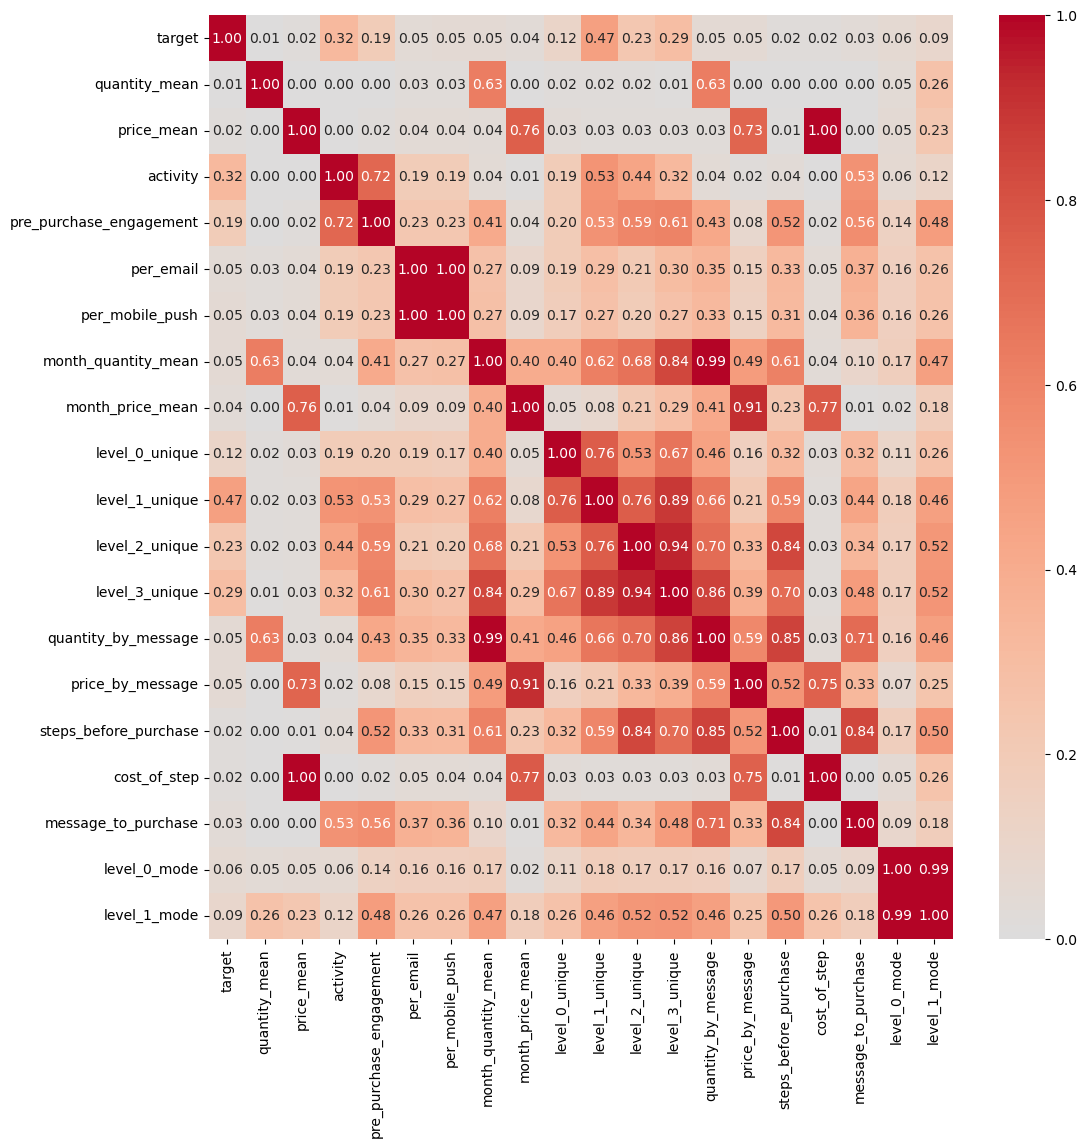

In [146]:
plt.figure(figsize=(12,12))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f');

В основном признаки плохо коррелируют с целевой переменной, но есть признаки, у которых корреляция больше 0,1 – их мы и будем использовать при обучении. Но необходимо удостовериться, что эти отобранные признаки не сильно коррелируют между собой. 

#### Отбор признаков

Отберем признаки с помощью функции select_features.

In [147]:
threshold = 0.05
features = select_features(phik_corr, 'target', threshold=threshold, multicollinearity_thresh=0.9)

In [148]:
features

['level_1_unique',
 'activity',
 'level_3_unique',
 'pre_purchase_engagement',
 'level_0_unique',
 'level_1_mode',
 'per_mobile_push',
 'price_by_message',
 'quantity_by_message']

### Создание обучающей и тестовой выборок

In [149]:
df = df[features+['target']]
df.head(2)

,level_1_unique,activity,level_3_unique,pre_purchase_engagement,level_0_unique,level_1_mode,per_mobile_push,price_by_message,quantity_by_message,target
0,1,0.03,1,1.0,1,18.0,0.65,1999.0,1.0,0
1,1,0.02,1,1.5,1,27.0,0.58,599.0,2.0,0


In [150]:
df.duplicated().sum()

464950

In [151]:
df = df.drop_duplicates()

In [152]:
df.shape

(37175, 10)

In [153]:
X = df[features]
y = df['target']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [155]:
X_train.shape

(22305, 9)

In [156]:
y_train.head(2)

166118    0
262049    0
Name: target, dtype: int64

## Обучение моделей

При обучении модели будем использовать 3 алгоритма: логистическая регрессия, случайный лес, градиентный бустинг.

### Логистическая регрессия

In [157]:
categorical_cols = ['level_1_mode'] 
numeric_cols = [el for el in features if el not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # StandardScaler для числовых колонок
        ('cat', OneHotEncoder(), categorical_cols)  # OHE для категориальной колонки
    ])

preprocessor.fit(X_train)

X_train_processed = pd.DataFrame(data=preprocessor.transform(X_train).toarray(),
                                 columns=preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(data=preprocessor.transform(X_test).toarray(),
                                 columns=preprocessor.get_feature_names_out())
X_train_processed.head(2)

,num__level_1_unique,num__activity,num__level_3_unique,num__pre_purchase_engagement,num__level_0_unique,num__per_mobile_push,num__price_by_message,num__quantity_by_message,cat__level_1_mode_0.0,cat__level_1_mode_12.0,...,cat__level_1_mode_5632.0,cat__level_1_mode_5633.0,cat__level_1_mode_5634.0,cat__level_1_mode_5683.0,cat__level_1_mode_5697.0,cat__level_1_mode_5837.0,cat__level_1_mode_5959.0,cat__level_1_mode_6057.0,cat__level_1_mode_6058.0,cat__level_1_mode_6059.0
0,-0.441319,-0.149006,0.099689,-0.053119,-0.39135,-0.909711,1.103804,0.417018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.441319,-0.813715,-0.519341,-0.485105,-0.39135,1.370860,-0.754864,-0.083868,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
pipeline = Pipeline([
    # ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', random_state=42, tol=1e-1))
    ])

param_grid = {
    'model__C':[0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='roc_auc')

In [159]:
get_metrics(grid_search, X_train_processed, y_train)

Лучшие параметры: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'saga'}
roc_auc = : 0.68


### Случайный лес

In [184]:
le = LabelEncoder()
le.fit(X_train['level_1_mode'])
X_train['level_1_mode_encode'] = le.transform(X_train['level_1_mode'])
X_test['level_1_mode_encode'] = le.transform(X_test['level_1_mode'])
X_train.head(2)

,level_1_unique,activity,level_3_unique,pre_purchase_engagement,level_0_unique,level_1_mode,per_mobile_push,price_by_message,quantity_by_message,level_1_mode_encode
166118,1,0.34,2,1.47,1,28.0,0.12,6798.0,3.0,6
262049,1,0.06,1,1.18,1,27.0,1.00,67.0,2.0,5


In [185]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1)

In [187]:
get_metrics(grid_search, X_train.drop(columns='level_1_mode'), y_train)

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}
roc_auc = : 0.70


#### Градиентный бустинг - Catboost

In [176]:
param_grid ={
    'depth': [4,6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1, 3, 5],
    'auto_class_weights': ['Balanced']
}

grid_search = GridSearchCV(
    CatBoostClassifier(verbose=0, random_state=42),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1)

grid_search.fit(X_train.drop(columns='level_1_mode'), y_train, cat_features=[8])

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001EE0EF8AD90>,
             n_jobs=-1,
             param_grid={'auto_class_weights': ['Balanced'], 'depth': [4, 6, 8],
                         'iterations': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='roc_auc')

In [177]:
grid_search.best_score_

0.6862848715224832

### Лучшая модель

Лучшая метрика roc_auc=0.71 у модели на основе алгоритма случайного леса с параметрами:
- max_depth = 5, 
- min_samples_leaf = 1, 
- n_estimators = 200.

Заново обучим эту модель с данными параметрами и проверим метрику roc_auc на тестовой выборке.


In [189]:
parameters = {
    'random_state':42,
    'class_weight':'balanced',
    'max_depth': 5,
    'min_samples_leaf': 1,
    'n_estimators': 200
}

model = RandomForestClassifier(**parameters)

model.fit(X_train.drop(columns='level_1_mode'), y_train)

roc_auc_score(model.predict(X_test.drop(columns='level_1_mode')), y_test)

0.5149376486287548

### Матрица ошибок

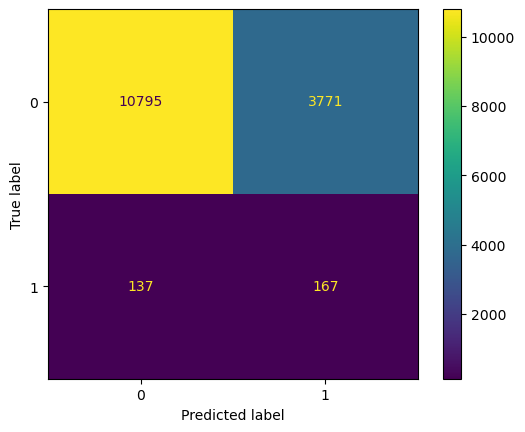

In [193]:
y_pred = model.predict(X_test.drop(columns='level_1_mode'))
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

In [194]:
report = classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"])
print(report)

              precision    recall  f1-score   support

     Class 0       0.99      0.74      0.85     14566
     Class 1       0.04      0.55      0.08       304

    accuracy                           0.74     14870
   macro avg       0.51      0.65      0.46     14870
weighted avg       0.97      0.74      0.83     14870



In [195]:
from sklearn.metrics import precision_recall_curve

In [213]:
y_pred_proba = model.predict_proba(X_test.drop(columns='level_1_mode'))[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

In [214]:
f1_scores = 2 * (precision * recall)/ (precision + recall)
best_thresholds = thresholds[np.argmax(f1_scores)]
best_thresholds

C:\Users\katkalov\AppData\Local\Temp\ipykernel_5676\3209173370.py:1: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall)/ (precision + recall)


0.8486791775241094

In [215]:
y_pred_adjusted = (y_pred_proba>=best_thresholds).astype(int)

In [216]:
report = classification_report(y_test, y_pred_adjusted, target_names=["Class 0", "Class 1"])
print(report)

              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97     14566
     Class 1       0.00      0.00      0.00       304

    accuracy                           0.95     14870
   macro avg       0.49      0.49      0.49     14870
weighted avg       0.96      0.95      0.96     14870



In [ ]:
y_pred_proba_0 = model.predict_proba(X_test.drop(columns='level_1_mode'))[:, 0]

thresholds = np.linspace (0, 1, 100)
f1_score = [f1_score(y_true, (y_pred_proba_0>=t).astype(int), pos_label=0 for t in thresholds]
                     